<a href="https://colab.research.google.com/github/zaki-m-khan/zaki-m-khan/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [10]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0", max_episode_steps=500)
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
num_episodes = 600
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
alpha = 1e-3
gamma = 0.99 # Added gamma hyperparameter
batch_size = 64
replay_buffer_size = 100000
target_update_freq = 2000
eval_every = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()  # we only use it for inference

target_update_freq = 1000
global_step = 0  # count environment steps


In [13]:
def epsilon_greedy(state, epsilon):
  ############ TODO ###########
  if np.random.rand() < epsilon:
      return np.random.randint(n_actions)
  # greedy action from current Q-network
  s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  with torch.no_grad():
      q = q_net(s)
  return int(torch.argmax(q, dim=1).item())


In [14]:
def train_dqn():
    """Train the DQN using experience replay and a target network."""
    if len(replay_buffer) < batch_size:
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Q(s,a) for the actions we actually took
    q_pred = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # max_a' Q_target(s', a')  (no grad)
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q * (1 - dones)

    loss = loss_fn(q_pred, targets)

    optimizer.zero_grad()
    loss.backward()

    # light gradient clipping to avoid exploding updates
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)

    optimizer.step()


In [15]:
## MAIN Loop ###
rewards_dqn = []
eval_every = 50  # how often to run a quick greedy evaluation

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0.0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # store transition
        replay_buffer.append((state, action, reward, next_state, float(done)))

        # one SGD step
        train_dqn()

        state = next_state
        total_reward += reward

        # count steps and update target net every K steps
        global_step += 1
        if global_step % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

    rewards_dqn.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # quick heartbeat every 10 eps (optional)
    if (episode + 1) % 10 == 0:
        print(f"ep {episode+1}: return={total_reward:.1f}, eps={epsilon:.3f}")

    # greedy eval every eval_every episodes
    if (episode + 1) % eval_every == 0:
        eval_returns = []
        for _ in range(3):
            s, _ = env.reset()
            done_eval, G = False, 0.0
            while not done_eval:
                a = epsilon_greedy(s, 0.0)  # greedy
                s, r, term, trunc, _ = env.step(a)
                done_eval = term or trunc
                G += r
            eval_returns.append(G)
        print(f"[eval ep {episode+1}] avg greedy return = {np.mean(eval_returns):.1f} | epsilon = {epsilon:.3f}")


ep 10: return=-500.0, eps=0.951
ep 20: return=-500.0, eps=0.905
ep 30: return=-500.0, eps=0.860
ep 40: return=-500.0, eps=0.818
ep 50: return=-500.0, eps=0.778
[eval ep 50] avg greedy return = -500.0 | epsilon = 0.778
ep 60: return=-500.0, eps=0.740
ep 70: return=-500.0, eps=0.704
ep 80: return=-500.0, eps=0.670
ep 90: return=-500.0, eps=0.637
ep 100: return=-500.0, eps=0.606
[eval ep 100] avg greedy return = -500.0 | epsilon = 0.606
ep 110: return=-500.0, eps=0.576
ep 120: return=-500.0, eps=0.548
ep 130: return=-500.0, eps=0.521
ep 140: return=-500.0, eps=0.496
ep 150: return=-500.0, eps=0.471
[eval ep 150] avg greedy return = -500.0 | epsilon = 0.471
ep 160: return=-500.0, eps=0.448
ep 170: return=-500.0, eps=0.427
ep 180: return=-500.0, eps=0.406
ep 190: return=-500.0, eps=0.386
ep 200: return=-500.0, eps=0.367
[eval ep 200] avg greedy return = -500.0 | epsilon = 0.367
ep 210: return=-500.0, eps=0.349
ep 220: return=-500.0, eps=0.332
ep 230: return=-500.0, eps=0.316
ep 240: return=

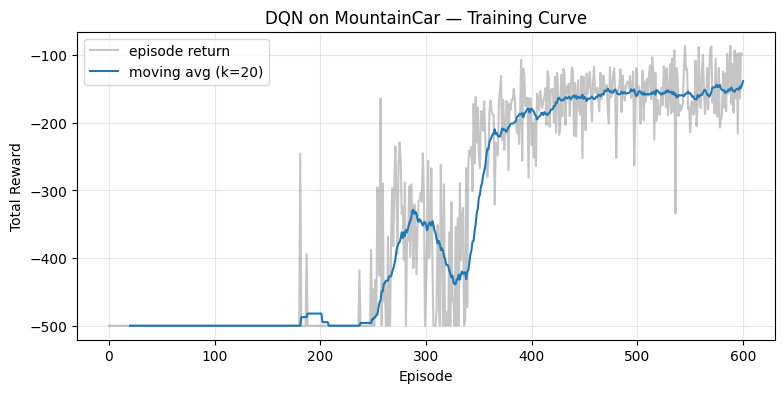

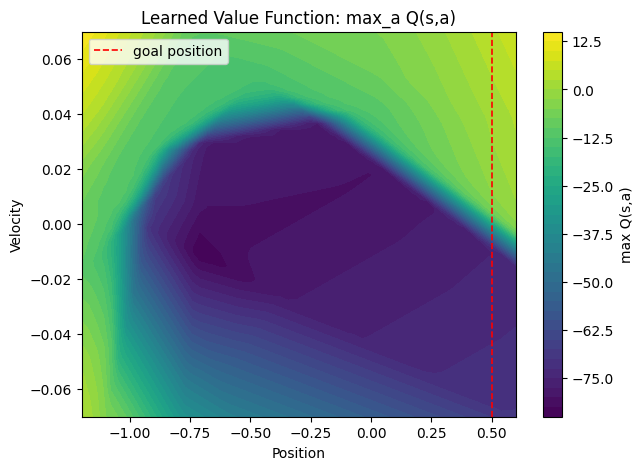

In [16]:
# ===========================
# Block 3 — Plots
#   - Episode vs Return
#   - Value function: max_a Q(s,a) over (position, velocity)
# ===========================
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------- 1) Episode vs Return ----------
def moving_average(x, k=20):
    if len(x) < k:
        return np.array(x, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[k:] - c[:-k]) / float(k)

plt.figure(figsize=(9,4))
plt.plot(rewards_dqn, color="gray", alpha=0.45, label="episode return")
ma = moving_average(rewards_dqn, k=20)
if len(ma) > 0:
    plt.plot(np.arange(len(ma)) + 20, ma, label="moving avg (k=20)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on MountainCar — Training Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --------- 2) Value function: max_a Q(s,a) ----------
# build a grid over state space
pos_min, vel_min = env.observation_space.low
pos_max, vel_max = env.observation_space.high

pos_vals = np.linspace(pos_min, pos_max, 60)
vel_vals = np.linspace(vel_min, vel_max, 60)
P, V = np.meshgrid(pos_vals, vel_vals)

# flatten into (N,2) states
states_grid = np.stack([P.ravel(), V.ravel()], axis=1)
states_t = torch.tensor(states_grid, dtype=torch.float32, device=device)

# compute max_a Q(s,a) for each grid state
with torch.no_grad():
    q_all = q_net(states_t)                 # shape: (N, 3)
    max_q = torch.max(q_all, dim=1)[0]      # shape: (N,)
Z = max_q.cpu().numpy().reshape(P.shape)

# contour plot (clean and readable)
plt.figure(figsize=(7,5))
cnt = plt.contourf(P, V, Z, levels=40, cmap="viridis")
plt.colorbar(cnt, label="max Q(s,a)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Learned Value Function: max_a Q(s,a)")
# mark the goal position line at x=0.5 (y location arbitrary within bounds)
plt.axvline(x=0.5, color="red", linestyle="--", linewidth=1.2, label="goal position")
plt.legend()
plt.show()

# # (optional) 3D surface — uncomment if you want it
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection="3d")
# surf = ax.plot_surface(P, V, Z, cmap="viridis", linewidth=0, antialiased=True)
# ax.set_xlabel("Position"); ax.set_ylabel("Velocity"); ax.set_zlabel("max Q(s,a)")
# ax.set_title("Value Surface (max Q)")
# fig.colorbar(surf, shrink=0.6, aspect=14)
# plt.show()

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [17]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409500 sha256=cd01e3fd54c8e399cd09e924cb89f7ebe60d62d5e12d2cd1dfcad8eab5d2bb55
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [19]:
# =========================
# DQN for LunarLander-v2
# =========================
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ---- Env ----
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n          # 4
state_dim = env.observation_space.shape[0]  # 8

# ---- Hyperparams (kept simple) ----
gamma = 0.99
alpha = 1e-3
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

num_episodes = 600
batch_size = 64
replay_buffer_size = 100_000
target_update_freq = 2000   # steps
eval_every = 50             # episodes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Q-network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Online + Target nets
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

# E-greedy
def epsilon_greedy(state, eps):
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q = q_net(s)
    return int(torch.argmax(q, dim=1).item())

# one SGD step from replay
def train_dqn():
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states      = torch.tensor(states, dtype=torch.float32, device=device)
    actions     = torch.tensor(actions, dtype=torch.long, device=device)
    rewards     = torch.tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    dones       = torch.tensor(dones, dtype=torch.float32, device=device)

    # Q(s,a)
    q_pred = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # target: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_pred, targets)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

# Train
rewards_dqn = []
global_step = 0

def moving_average(x, k=20):
    if len(x) < k: return np.array([])
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[k:] - c[:-k]) / float(k)

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    ep_ret = 0.0
    steps = 0

    while not done:
        action = epsilon_greedy(state, epsilon)
        ns, r, term, trunc, _ = env.step(action)
        done = term or trunc

        replay_buffer.append((state, action, r, ns, float(done)))
        train_dqn()

        state = ns
        ep_ret += r
        steps += 1
        global_step += 1

        if global_step % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

    rewards_dqn.append(ep_ret)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 10 == 0:
        print(f"ep {episode+1}: return={ep_ret:.1f}, eps={epsilon:.3f}")

    # quick greedy eval ping
    if (episode + 1) % eval_every == 0:
        eval_returns = []
        for _ in range(5):
            s, _ = env.reset()
            done_eval, G = False, 0.0
            while not done_eval:
                a = epsilon_greedy(s, 0.0)
                s, r, te, tr, _ = env.step(a)
                done_eval = te or tr
                G += r
        print(f"[eval {episode+1}] avg greedy return = {np.mean(eval_returns or [G]):.1f}  eps={epsilon:.3f}")


ep 10: return=-327.7, eps=0.951
ep 20: return=-260.4, eps=0.905
ep 30: return=-50.2, eps=0.860
ep 40: return=-165.3, eps=0.818
ep 50: return=-86.6, eps=0.778
[eval 50] avg greedy return = -197.0  eps=0.778
ep 60: return=-71.0, eps=0.740
ep 70: return=-211.8, eps=0.704
ep 80: return=-66.5, eps=0.670
ep 90: return=-77.8, eps=0.637
ep 100: return=-85.5, eps=0.606
[eval 100] avg greedy return = -145.7  eps=0.606
ep 110: return=-75.5, eps=0.576
ep 120: return=-23.5, eps=0.548
ep 130: return=-76.5, eps=0.521
ep 140: return=-45.4, eps=0.496
ep 150: return=-258.2, eps=0.471
[eval 150] avg greedy return = -255.4  eps=0.471
ep 160: return=-9.3, eps=0.448
ep 170: return=-139.8, eps=0.427
ep 180: return=-135.0, eps=0.406
ep 190: return=-10.2, eps=0.386
ep 200: return=-55.4, eps=0.367
[eval 200] avg greedy return = -337.8  eps=0.367
ep 210: return=7.5, eps=0.349
ep 220: return=-16.0, eps=0.332
ep 230: return=-15.9, eps=0.316
ep 240: return=104.2, eps=0.300
ep 250: return=156.5, eps=0.286
[eval 250]

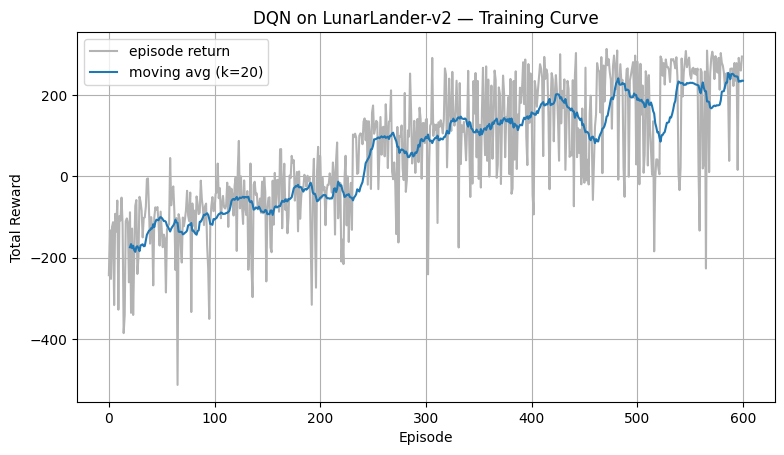

Evaluation Episode 0: Total Reward = 275.5854877212481
Evaluation Episode 1: Total Reward = 233.2424991060182
Evaluation Episode 2: Total Reward = 276.80579217365556
Evaluation Episode 3: Total Reward = 287.3462613097756
Evaluation Episode 4: Total Reward = 131.92579888563978
Evaluation Episode 5: Total Reward = 264.8082359964196
Evaluation Episode 6: Total Reward = 295.3737929282644
Evaluation Episode 7: Total Reward = 261.59830106071786
Evaluation Episode 8: Total Reward = 272.8509960686391
Evaluation Episode 9: Total Reward = 277.19064722739785


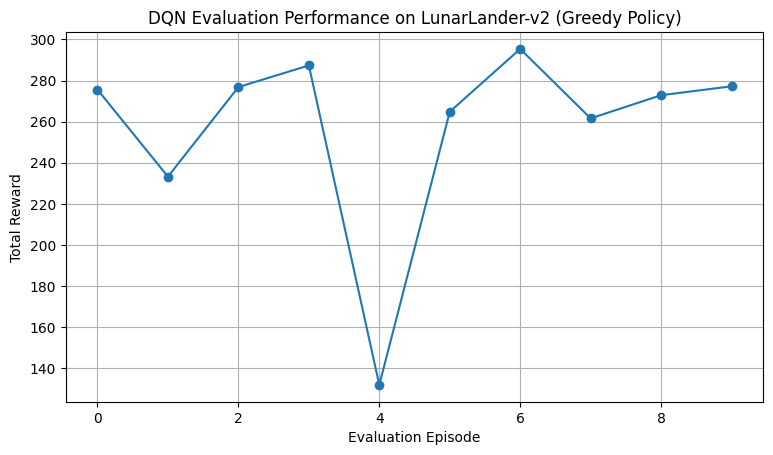


Average reward over 10 evaluation episodes: 257.67


In [21]:
# =========================
# Block 2 — Plots + Greedy Eval
# =========================
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) Training curve: episode return + moving average
def moving_avg(arr, k=20):
    if len(arr) < k:
        return np.array([])
    c = np.cumsum(np.insert(arr, 0, 0.0))
    return (c[k:] - c[:-k]) / float(k)

ma = moving_avg(rewards_dqn, k=20)

plt.figure(figsize=(9, 4.8))
plt.plot(rewards_dqn, color="0.7", label="episode return")
if len(ma) > 0:
    plt.plot(np.arange(len(ma)) + 20, ma, label="moving avg (k=20)")
plt.title("DQN on LunarLander-v2 — Training Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

# 2) Greedy evaluation (E = 0.0)
def eval_greedy(env, q_net, episodes=10):
    q_net.eval()
    returns = []
    for i in range(episodes):
        s, _ = env.reset()
        done = False
        G = 0.0
        while not done:
            st = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                a = int(torch.argmax(q_net(st), dim=1).item())
            s, r, term, trunc, _ = env.step(a)
            done = term or trunc
            G += r
        returns.append(G)
        print(f"Evaluation Episode {i}: Total Reward = {G}")
    return np.array(returns, dtype=np.float32)

eval_rewards = eval_greedy(env, q_net, episodes=10)

plt.figure(figsize=(9, 4.8))
plt.plot(eval_rewards, marker="o")
plt.title("DQN Evaluation Performance on LunarLander-v2 (Greedy Policy)")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

print(f"\nAverage reward over {len(eval_rewards)} evaluation episodes: {eval_rewards.mean():.2f}")
